# Modelo ML: Pronosticar cancelación de suscripciones

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing ha recopilado algunos de los datos personales de sus clientes.

Interconnect proporciona principalmente dos tipos de servicios: Comunicación por teléfono fijo e Internet.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*DeviceProtection*) y un bloqueador de sitios web maliciosos (*OnlineSecurity*).
- Una línea de soporte técnico (*TechSupport*).
- Almacenamiento de archivos en la nube y backup de datos (*OnlineBackup*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingMovies*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

Para la predicción, se crean **modelos de clasificación** los cuales se comparan para elegir el mejor.

Como métrica principal para evluar el modelo se usa el valor **AUC-ROC**, es decir el área bajo la curva Característica operativa del receptor *(AUC-ROC: Area under the curve - Receiver Operating Characteristic)*. Esta se usa para medir el acierto en la predicción de eventos binarios.

Como métrica adicional se usa el valor de exactitud

## Tabla de contenido
- Plan de trabajo
- Inicialización
- Preprocesamiento de datos
- Análisis exploratorio de datos (EDA)
 - Correlación de variables
- Entrenamiento y evaluación de modelos
 - Preparar conjuntos de datos
 - Función para evaluar modelos
 - Modelos de regresión logística
 - Modelos de árbol de clasificación
 - Modelos de bosque aleatorio para clasificación
 - Modelos CatBoostClassifier
- Conclusiones

## Plan de trabajo

1. Vista previa y preprocesamiento de datos
2. Hacer un análisis exploratorio de datos (EDA)
 - Incluir correlación de variables

3. Adaptar las posibles características para los entrenamientos de distintos modelos, como transformar las variables categóricas en numéricas segun lo requiera el modelo.

4. Entrenar distintos modelos predictivos con los datos
 - Al separar el conjunto de entrenamiento y prueba, cuidar que el conjunto de entrenamiento tenga datos de contratos cancelados
 - Hacer pruebas con distintos hiperparámetros
 - Tomar como métrica principal el valor AUC-ROC
 - Tomar como métrica adicional la exactitud

5. Comparar los resultados de los modelos

## Inicialización

In [1]:
#instalar catboost
pip install catboost

In [2]:
#importar librerias
import pandas as pd
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

Se cuenta con 4 archivos:
- `contract.csv` — información del contrato
- `personal.csv` — datos personales del cliente
- `internet.csv` — información sobre los servicios de Internet
- `phone.csv` — información sobre los servicios telefónicos

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente.

In [3]:
#cargar datos
contract = pd.read_csv('https://raw.githubusercontent.com/IreneRA/TripleTen-LatAm/16-final/contract.csv', parse_dates = [1])
internet = pd.read_csv('https://raw.githubusercontent.com/IreneRA/TripleTen-LatAm/16-final/internet.csv')
personal = pd.read_csv('https://raw.githubusercontent.com/IreneRA/TripleTen-LatAm/16-final/personal.csv')
phone = pd.read_csv('https://raw.githubusercontent.com/IreneRA/TripleTen-LatAm/16-final/phone.csv')

In [4]:
#examinar tamaño de dfs
for df in [contract, internet, personal, phone]:
  print(df.shape)

(7043, 8)

(5517, 8)

(7043, 5)

(6361, 2)


Se oberva que los dfs `contract` y `personal` tienen el mismo número de datos.

La inconsistencia en la cantidad de información/renglones, podría deberse a que no todos los usuarios con plan telefónico tienen plan de internet y viceversa.

**Vista previa de los conjuntos de datos**

In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Información general de los conjuntos de datos**

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype         

---  ------            --------------  -----         

 0   customerID        7043 non-null   object        

 1   BeginDate         7043 non-null   datetime64[ns]

 2   EndDate           7043 non-null   object        

 3   Type              7043 non-null   object        

 4   PaperlessBilling  7043 non-null   object        

 5   PaymentMethod     7043 non-null   object        

 6   MonthlyCharges    7043 non-null   float64       

 7   TotalCharges      7043 non-null   object        

dtypes: datetime64[ns](1), float64(1), object(6)

memory usage: 440.3+ KB


No hay valores ausentes pero la columna `TotalCharges` tiene el tipo de dato incorrecto.

In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5517 entries, 0 to 5516

Data columns (total 8 columns):

 #   Column            Non-Null Count  Dtype 

---  ------            --------------  ----- 

 0   customerID        5517 non-null   object

 1   InternetService   5517 non-null   object

 2   OnlineSecurity    5517 non-null   object

 3   OnlineBackup      5517 non-null   object

 4   DeviceProtection  5517 non-null   object

 5   TechSupport       5517 non-null   object

 6   StreamingTV       5517 non-null   object

 7   StreamingMovies   5517 non-null   object

dtypes: object(8)

memory usage: 344.9+ KB


No hay valores ausentes pero la mayoría de las columnas podría cambiarse a tipo de dato booleano para facilitar la creación del modelo.

In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 7043 entries, 0 to 7042

Data columns (total 5 columns):

 #   Column         Non-Null Count  Dtype 

---  ------         --------------  ----- 

 0   customerID     7043 non-null   object

 1   gender         7043 non-null   object

 2   SeniorCitizen  7043 non-null   int64 

 3   Partner        7043 non-null   object

 4   Dependents     7043 non-null   object

dtypes: int64(1), object(4)

memory usage: 275.2+ KB


In [12]:
phone.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 6361 entries, 0 to 6360

Data columns (total 2 columns):

 #   Column         Non-Null Count  Dtype 

---  ------         --------------  ----- 

 0   customerID     6361 non-null   object

 1   MultipleLines  6361 non-null   object

dtypes: object(2)

memory usage: 99.5+ KB


No hay valores ausentes en ninguno de los conjuntos.

## Preprocesamiento de datos

In [13]:
#unir todas las tablas
df = contract.merge(internet, how='left', on='customerID')
df = df.merge(personal, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')

df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No


Se crea la columna objetivo a partir de la columna `EndDate`. Por ello, esta última no podra ser tomada en cuenta para la construcción del modelo.

In [14]:
#crear columna objetivo
df['Target'] = (df['EndDate'] != "No").astype("int")
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 7043 entries, 0 to 7042

Data columns (total 21 columns):

 #   Column            Non-Null Count  Dtype         

---  ------            --------------  -----         

 0   customerID        7043 non-null   object        

 1   BeginDate         7043 non-null   datetime64[ns]

 2   EndDate           7043 non-null   object        

 3   Type              7043 non-null   object        

 4   PaperlessBilling  7043 non-null   object        

 5   PaymentMethod     7043 non-null   object        

 6   MonthlyCharges    7043 non-null   float64       

 7   TotalCharges      7043 non-null   object        

 8   InternetService   5517 non-null   object        

 9   OnlineSecurity    5517 non-null   object        

 10  OnlineBackup      5517 non-null   object        

 11  DeviceProtection  5517 non-null   object        

 12  TechSupport       5517 non-null   object        

 13  StreamingTV       5517 non-null   object        

 14  Strea

**Cambiar tipos de datos erroneos**

In [16]:
#buscar valor que no es numéricoo
df['TotalCharges'].value_counts().sort_values().tail()

19.9      8
20.05     8
19.75     9
20.2     11
         11
Name: TotalCharges, dtype: int64

In [17]:
#explorar filas con valor ausente en columna TotalCharges
df[df['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,No,Yes,No,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,...,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,...,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,DSL,No,...,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes,0


In [18]:
df['BeginDate'].describe(datetime_is_numeric=True)

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object

La cantidad de valores ausentes en la columna `TotalCharges` es mínima y muestra información sobre clientes nuevos por lo que se pueden eliminar estas filas sin afectar el modelo.

In [19]:
#eliminar renglones con valores ausentes en columna TotalCharges
df = df[df['TotalCharges'] != ' ']

In [20]:
#cambiar columna TotalCharges a tipo float
df['TotalCharges'] = df['TotalCharges'].astype('float')

<ipython-input-20-233c1e890abc>:2: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['TotalCharges'] = df['TotalCharges'].astype('float')


In [21]:
#cambiar columnas valores de 0 y 1
yn_columns = ['PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Partner','Dependents', 'MultipleLines']

#asignar 0 a todos los usuarios que no tengan cierto servicio y cambiar tipo de dato
for col in yn_columns:
  df.loc[df[col] == 'Yes', col] = 1
  df.loc[df[col] != 1, col] = 0

  df[col] = df[col].astype('int')

<ipython-input-21-b7768aacad3c>:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col] = df[col].astype('int')


In [22]:
#verificar cambios
df.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 7032 entries, 0 to 7042

Data columns (total 21 columns):

 #   Column            Non-Null Count  Dtype         

---  ------            --------------  -----         

 0   customerID        7032 non-null   object        

 1   BeginDate         7032 non-null   datetime64[ns]

 2   EndDate           7032 non-null   object        

 3   Type              7032 non-null   object        

 4   PaperlessBilling  7032 non-null   int64         

 5   PaymentMethod     7032 non-null   object        

 6   MonthlyCharges    7032 non-null   float64       

 7   TotalCharges      7032 non-null   float64       

 8   InternetService   5512 non-null   object        

 9   OnlineSecurity    7032 non-null   int64         

 10  OnlineBackup      7032 non-null   int64         

 11  DeviceProtection  7032 non-null   int64         

 12  TechSupport       7032 non-null   int64         

 13  StreamingTV       7032 non-null   int64         

 14  Strea

Ya no hay valores ausentes

**Explorar columnas categóricas**

In [23]:
#buscar usuarios duplicados
df['customerID'].duplicated().sum()

0

In [24]:
#explorar columnas categóricas
for col in ['Type', 'PaymentMethod', 'InternetService','gender']:
  print(col)
  print(df[col].unique())
  print()

Type

['Month-to-month' 'One year' 'Two year']



PaymentMethod

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'

 'Credit card (automatic)']



InternetService

['DSL' 'Fiber optic' nan]



gender

['Female' 'Male']




In [25]:
#rellenar valores ausentes de columna InternetService
df['InternetService'] = df['InternetService'].fillna('None')

#verificar cambios
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'None'], dtype=object)

**Explorar columnas numéricas**

In [26]:
df[['MonthlyCharges', 'TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


**Explorar columnas booleanas**

In [27]:
bool_col = ['PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']

for col in bool_col:
  print(df[col].value_counts(normalize=True))
  print()

1    0.592719

0    0.407281

Name: PaperlessBilling, dtype: float64



0    0.713453

1    0.286547

Name: OnlineSecurity, dtype: float64



0    0.655148

1    0.344852

Name: OnlineBackup, dtype: float64



0    0.656143

1    0.343857

Name: DeviceProtection, dtype: float64



0    0.709898

1    0.290102

Name: TechSupport, dtype: float64



0    0.615614

1    0.384386

Name: StreamingTV, dtype: float64



0    0.611633

1    0.388367

Name: StreamingMovies, dtype: float64



0    0.8376

1    0.1624

Name: SeniorCitizen, dtype: float64



0    0.517491

1    0.482509

Name: Partner, dtype: float64



0    0.701507

1    0.298493

Name: Dependents, dtype: float64



0    0.578072

1    0.421928

Name: MultipleLines, dtype: float64




**Explorar columnas con fechas**

In [28]:
df['BeginDate'].describe(datetime_is_numeric=True)

count                             7032
mean     2017-04-28 23:14:44.641638400
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-01-01 00:00:00
Name: BeginDate, dtype: object

In [29]:
# comprobar que las fechas estan en orden
df['BeginDate'].is_monotonic_increasing

False

In [30]:
#ordenar fechas
df = df.sort_values('BeginDate')

In [31]:
#información de clientes dados de baja
end_date = df[df['EndDate'] != 'No'].copy()
end_date['EndDate'] = pd.to_datetime(end_date['EndDate'])

In [32]:
#cancelaciones del contrato por fecha
end_date['EndDate'].describe(datetime_is_numeric=True)

count                             1869
mean     2019-11-15 21:31:18.009630720
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: EndDate, dtype: object

Se tienen fechas de inicio de contratos desde el 1 de octubre de 2013, hasta el 1 de enero 2020. Sin embargo, se tienen fechas de cancelaciones desde el 1 de octubre de 2019 hasta el 1 de enero 2020.

Todas las columnas tienen una cantidad significativa de datos en ambas categorías por lo que actualmente ninguna se considera una característica irrelevante para el modelo.

## Análisis exploratorio de datos (EDA)

In [33]:
#explorar columna objetivo
df['Target'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Target, dtype: float64

El 26.58% de los usuarios cancelan el servicio

**Explorar por fecha**

In [34]:
#configurar BeginDate como indice
df.set_index(keys='BeginDate', inplace=True)

# comprobar que las fechas estan en orden
df.index.is_monotonic_increasing

True

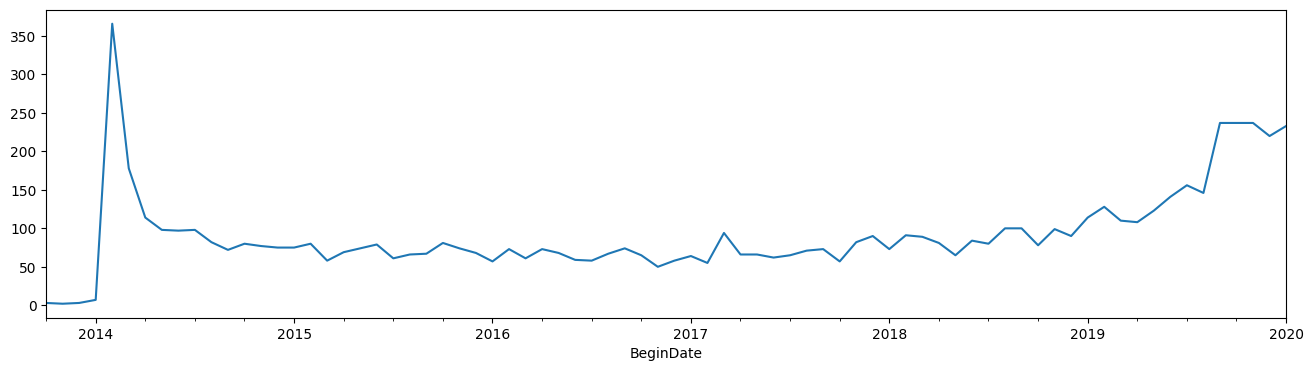

In [35]:
#inicializaciones del contrato por mes
df.resample('1M')['Target'].count().plot(figsize=(16,4))
plt.show()

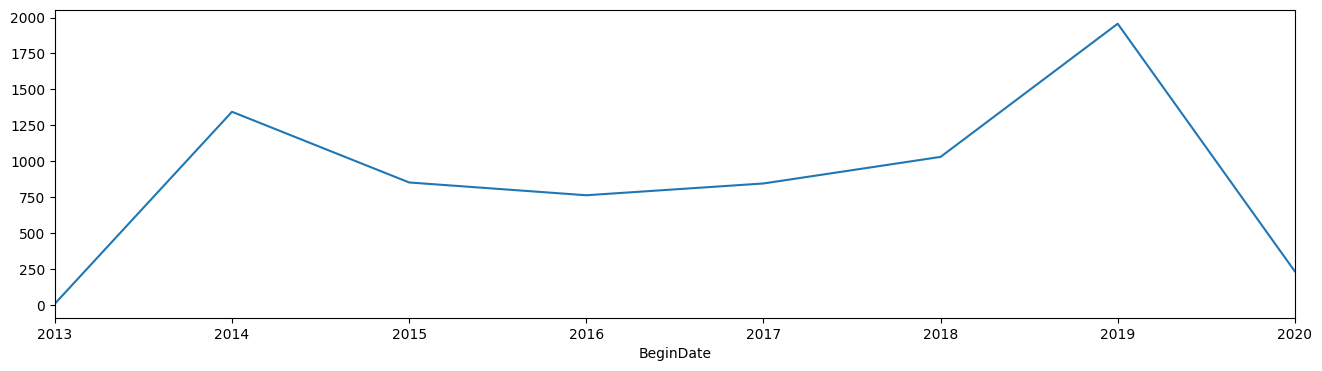

In [36]:
#inicializaciones del contrato por año
df.resample('1Y')['Target'].count().plot(figsize=(16,4))
plt.show()

Se observa un alto número de inicio de contratos alrededor del 2014. Nuevamente, en el año 2019 incrementa este número.

In [37]:
#configurar EndDate como indice
end_date.set_index(keys='EndDate', inplace=True)

In [38]:
#fechas de inicio de contratos cancelados
end_date['BeginDate'].describe(datetime_is_numeric=True)

count                             1869
mean     2018-05-17 13:04:20.032102656
min                2013-10-01 00:00:00
25%                2017-07-01 00:00:00
50%                2019-02-01 00:00:00
75%                2019-09-01 00:00:00
max                2019-12-01 00:00:00
Name: BeginDate, dtype: object

Al observar únicamente los contratos cancelados, la mitad corresponde a contratos iniciados entre 2013 y 2018 y la otra mitad iniciaron en febrero 2019.

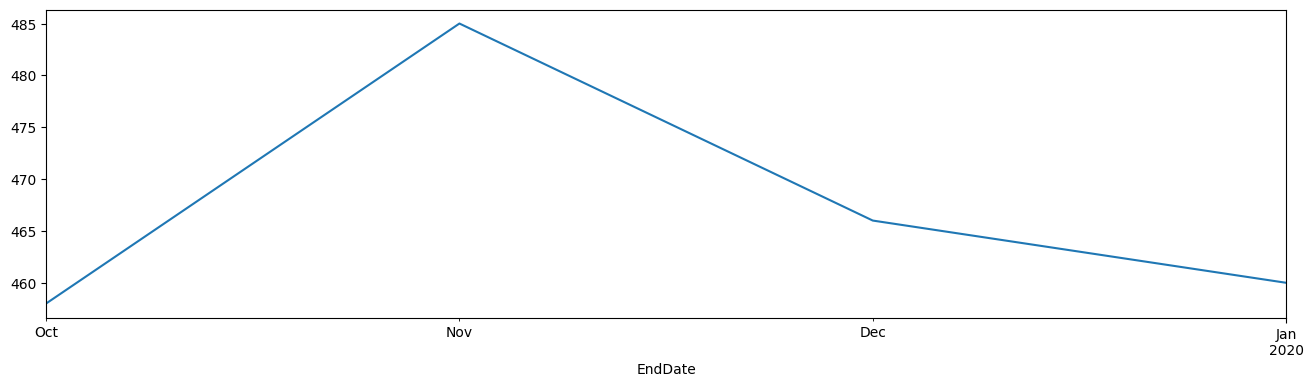

In [39]:
#cancelaciones por mes
end_date.resample('1M')['Target'].sum().plot(figsize=(16,4))
plt.xlim()
plt.show()

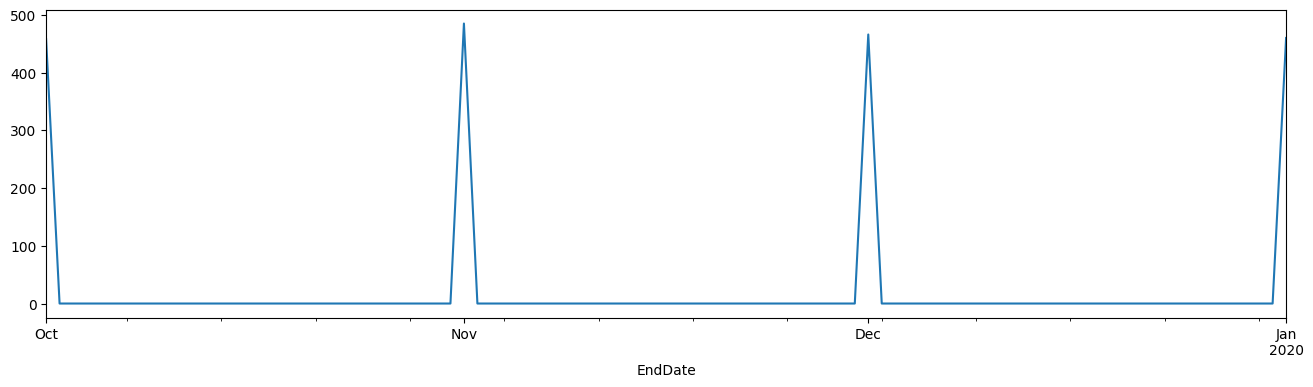

In [40]:
#cancelaciones por dia
end_date.resample('1D')['Target'].sum().plot(figsize=(16,4))
plt.xlim()
plt.show()

Las cancelaciones iniciaron en octubre del 2019, incrementaron durante noviembre y disminuyeron nuevamente en diciembre.

Solo hay registro de cancelaciones al cambiar el mes, probablemente cerca de la fecha de cobro.

### Correlación de variables - datos históricos

**Correlación de variables numéricas**

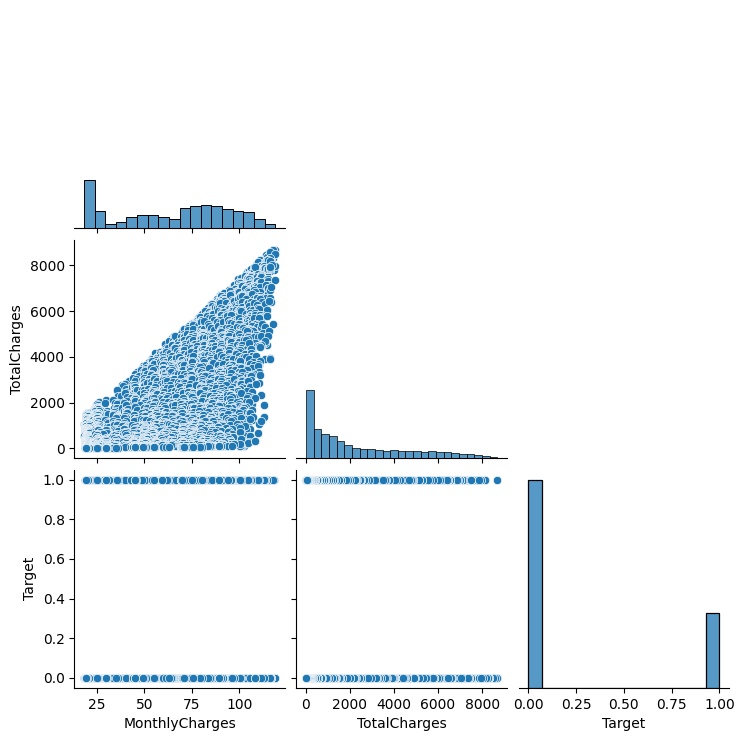

In [41]:
#matriz de dispersión
sns.pairplot(df[['MonthlyCharges', 'TotalCharges', 'Target']],corner=True)
plt.show()

In [42]:
#matriz de correlación características numéricas
df[['MonthlyCharges', 'TotalCharges', 'Target']].corr()

,MonthlyCharges,TotalCharges,Target
MonthlyCharges,1.000000,0.651065,0.192858
TotalCharges,0.651065,1.000000,-0.199484
Target,0.192858,-0.199484,1.000000


Esto muestra que hay una ligera relación positiva entre la columna objetivo y la columna `MonthlyCharges`. Por el contrario, hay una ligera relación negativa entre la columna objetivo y la columna `TotalCharges`.

**Correlación de variables booleanas**

In [43]:
bool_col.append('Target')

#matriz de correlación características booleanas
df[bool_col].corr()['Target'].sort_values()

OnlineSecurity     -0.171270
TechSupport        -0.164716
Dependents         -0.163128
Partner            -0.149982
OnlineBackup       -0.082307
DeviceProtection   -0.066193
MultipleLines       0.040033
StreamingMovies     0.060860
StreamingTV         0.063254
SeniorCitizen       0.150541
PaperlessBilling    0.191454
Target              1.000000
Name: Target, dtype: float64

Esto muestra que hay una ligera relación negativa entre la columna objetivo y las columnas:
- `OnlineSecurity`
- `TechSupport`
- `Dependents`
- `Partner`

Hay una ligera relación positiva entre la columna objetivo y las columnas:
- `PaperlessBilling`
- `SeniorCitizen`

Hay una relación casi nula (menor a 0.10) entre la columna objetivo y el resto de las columnas.

**Variables categóricas**

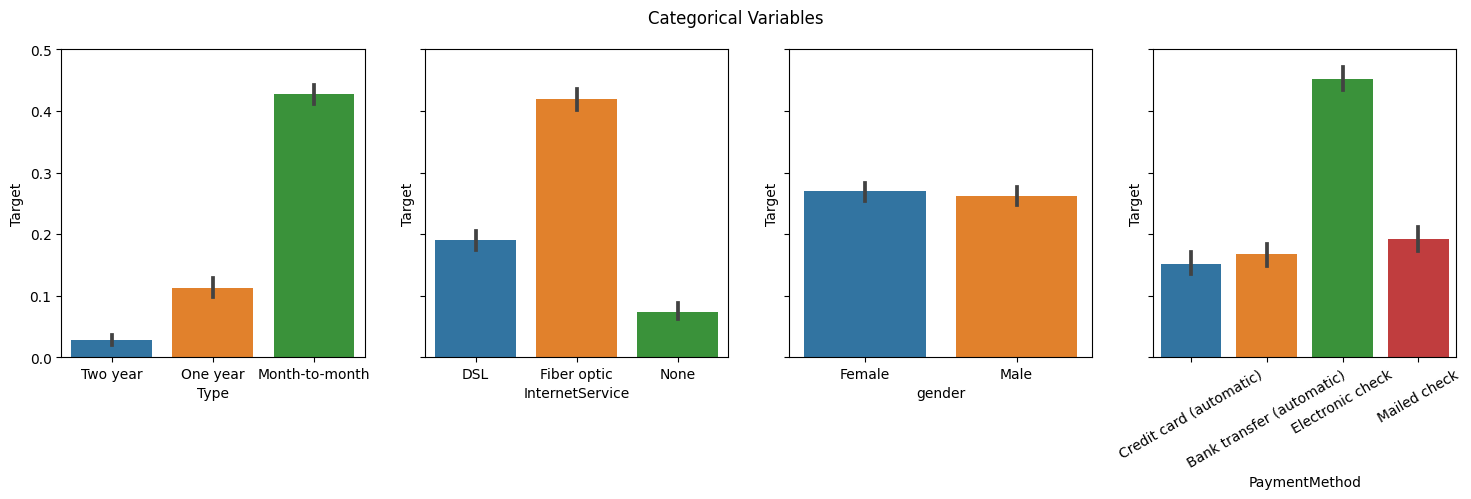

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)
fig.suptitle('Categorical Variables')

sns.barplot(ax=axes[0], data=df, x='Type', y='Target')
sns.barplot(ax=axes[1], data=df, x='InternetService', y='Target')
sns.barplot(ax=axes[2], data=df, x='gender', y='Target')
sns.barplot(ax=axes[3], data=df, x='PaymentMethod', y='Target')
plt.xticks(rotation=30)
plt.ylim(0,0.5)
plt.show()

En cuanto al **tipo de pago**, los clientes con menor tasa de cancelación son los que pagan anualmente o cada dos años.

En el **servicio de internet**, lo clientes con mayor porcentaje de cancelación son los que cuentan con fibra óptica, seguidos de los que usan una línea telefónica (DSL) y los de menor tasa son los que no contratan el servicio de internet.

La característica **género** no muestra relación con la columna objetivo, en promedio la misma cantidad de hombres y mujeres cancelan los contratos.

En cuanto al **método de pago**, los clientes con mayor tasa de cancelación son los que pagan con cheque electrónico. En los demás no hay una diferencia significativa.

## Entrenamiento y evaluación de modelos

### Preparar conjuntos de datos
En las columnas `PaymentMethod` y `Type` se agrupan las categorías que son similares, en cuanto a la tasa de cancelación.

In [45]:
#agrupar categorías de columna PaymentMethod
df.loc[df['PaymentMethod'] != 'Electronic check', 'PaymentMethod'] = 'Other'
df['PaymentMethod'].unique()

array(['Other', 'Electronic check'], dtype=object)

In [46]:
#agrupar categorías de columna Type
df.loc[df['Type'] != 'Month-to-month', 'Type'] = '1 or 2 years'
df['Type'].unique()

array(['1 or 2 years', 'Month-to-month'], dtype=object)

Se eliminan la columnas que no son relevantes para el entrenamiento del modelo como la columna `customerID`, la columna `gender` que no muestra influencia en el objetivo y la columna `EndDate` que forma parte de la característica objetivo.



In [47]:
#fijar características para entrenar al modelo
df = df.drop(columns=['customerID', 'EndDate', 'gender'])

Se crean 2 conjuntos de datos, uno histórico y otro con datos únicamente del 2019.
 - Se crean los conjuntos de entrenamiento y prueba
 - Se transforman las características categóricas con OHE

**Datos históricos**

In [48]:
#separar características de objetivo
features = df.drop(['Target'],axis=1)
target = df['Target']

#separar conjunto de entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

**Balancear datos**

Se balancean los datos de entrenamiento al duplicar los datos con cancelaciones pues hay pocas.

In [49]:
#función para balancear datos
def upsample(features, target):
  repeat = 2

  #Separar respuestas de conjunto de datos de entrenamiento
  features_zeros = features[target == 0]
  features_ones = features[target == 1]
  target_zeros = target[target == 0]
  target_ones = target[target == 1]

  #Aumentar observaciones positivas (donde cancelaron)
  features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
  target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

  #reordenar datos por fecha
  features_upsampled.sort_index(inplace=True)
  target_upsampled.sort_index(inplace=True)

  return features_upsampled, target_upsampled

In [50]:
#aumentar datos de cancelaciones
features_train, target_train = upsample(features_train, target_train)

In [51]:
#comprobar que los datos de entrenamiento son de fechas anteriores a los datos de prueba y que contengan contratos cancelados
print('Training set date range: ', features_train.index.min(),' - ', features_train.index.max())
print('Test set date range: ', features_test.index.min(), ' - ',features_test.index.max())

Training set date range:  2013-10-01 00:00:00  -  2019-10-01 00:00:00

Test set date range:  2019-10-01 00:00:00  -  2020-01-01 00:00:00


**Escalar datos**

In [52]:
#explorar columnas numéricas
df[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


Las columnas númericas tienen distintas escalas, los valores mínimos oscilan desde 1 hasta 2013; mientras que los valores máximos oscilan desde 12 hasta 8684.8. Por ello, se estandarizan para darles la misma importancia y así mejorar el modelo.

Primero se escalan todos los datos para más adelante verificar la calidad de los modelos por medio de validación cruzada.

In [53]:
#escalar todos los datos
features[['MonthlyCharges','TotalCharges']] = StandardScaler().fit_transform(features[['MonthlyCharges','TotalCharges']])

#Verificar cambios
features[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7.032000e+03,7.032000e+03
mean,6.466828e-17,1.293366e-16
std,1.000071e+00,1.000071e+00
min,-1.547283e+00,-9.990692e-01
25%,-9.709769e-01,-8.302488e-01
50%,1.845440e-01,-3.908151e-01
75%,8.331482e-01,6.668271e-01
max,1.793381e+00,2.824261e+00


**Datos históricos escalados sin OHE**

In [54]:
#función para escalar datos
def scale_data(features_train, features_test):
  #establecer escalador y entrenarlo con datos de entrenamiento
  scaler = StandardScaler()
  scaler.fit(features_train[['MonthlyCharges','TotalCharges']])

  #escalar las características de todos los conjuntos de datos
  features_train[['MonthlyCharges','TotalCharges']] = scaler.transform(features_train[['MonthlyCharges','TotalCharges']])
  features_test[['MonthlyCharges','TotalCharges']]  = scaler.transform(features_test[['MonthlyCharges','TotalCharges']])

  #Verificar cambios
  print(features_train[['MonthlyCharges','TotalCharges']].describe())

  return features_train, features_test

In [55]:
#escalar datos
features_train, features_test = scale_data(features_train, features_test)

       MonthlyCharges  TotalCharges

count    7.952000e+03   7952.000000

mean    -2.573394e-16      0.000000

std      1.000063e+00      1.000063

min     -1.731691e+00     -1.059395

25%     -7.798430e-01     -0.825457

50%      2.200266e-01     -0.387128

75%      8.310105e-01      0.664779

max      1.715544e+00      2.845271


**Datos históricos escalados con OHE**

Aplicar codificación One-Hot (OHE) para transformar características categóricas en numéricas y escalar datos.

Nuevamente, se escalan todos los datos para más adelante verificar la calidad de los modelos por medio de validación cruzada.

In [56]:
#aplicar OHE
features_ohe = pd.get_dummies(features,drop_first=True)

In [57]:
#escalar todos los datos
features_ohe[['MonthlyCharges','TotalCharges']] = StandardScaler().fit_transform(features_ohe[['MonthlyCharges','TotalCharges']])

#Verificar cambios
features_ohe[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7032.000000,7.032000e+03
mean,0.000000,-6.466828e-17
std,1.000071,1.000071e+00
min,-1.547283,-9.990692e-01
25%,-0.970977,-8.302488e-01
50%,0.184544,-3.908151e-01
75%,0.833148,6.668271e-01
max,1.793381,2.824261e+00


In [58]:
#separar conjunto de entrenamiento y prueba
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target, test_size=0.1, shuffle=False)

In [59]:
#aumentar datos de cancelaciones
features_train_ohe, target_train_ohe = upsample(features_train_ohe, target_train_ohe)

In [60]:
#comprobar que los datos de entrenamiento son de fechas anteriores a los datos de prueba y que contengan contratos cancelados
print('Training set date range: ', features_train_ohe.index.min(),' - ', features_train_ohe.index.max())
print('Test set date range: ', features_test_ohe.index.min(), ' - ',features_test_ohe.index.max())

Training set date range:  2013-10-01 00:00:00  -  2019-10-01 00:00:00

Test set date range:  2019-10-01 00:00:00  -  2020-01-01 00:00:00


In [61]:
#escalar datos
features_train_ohe, features_test_ohe = scale_data(features_train_ohe, features_test_ohe)

       MonthlyCharges  TotalCharges

count     7952.000000   7952.000000

mean         0.000000      0.000000

std          1.000063      1.000063

min         -1.731691     -1.059395

25%         -0.779843     -0.825457

50%          0.220027     -0.387128

75%          0.831010      0.664779

max          1.715544      2.845271


**Datos del año 2019**

Se crean a partir del dataset histórico.

In [62]:
#crear conjunto de datos del año 2019
df19 = df[df.index>'2018-12-31']

In [63]:
#separar características de objetivo
features19 = df19.drop(['Target'],axis=1)
target19 = df19['Target']

#separar conjunto de entrenamiento y prueba
features_train19, features_test19, target_train19, target_test19 = train_test_split(features19, target19, test_size=0.2, shuffle=False)

In [64]:
#aumentar datos de cancelaciones
features_train19, target_train19 = upsample(features_train19, target_train19)

In [65]:
#comprobar que los datos de entrenamiento son de fechas anteriores a los datos de prueba y que contengan contratos cancelados
print('Training set date range: ', features_train19.index.min(),' - ', features_train19.index.max())
print('Test set date range: ', features_test19.index.min(), ' - ',features_test19.index.max())

Training set date range:  2019-01-01 00:00:00  -  2019-12-01 00:00:00

Test set date range:  2019-12-01 00:00:00  -  2020-01-01 00:00:00


**Datos del año 2019 escalados sin OHE**

Nuevamente, se escalan todos los datos para más adelante verificar la calidad de los modelos por medio de validación cruzada.

In [66]:
#escalar todos los datos
features19[['MonthlyCharges','TotalCharges']] = StandardScaler().fit_transform(features19[['MonthlyCharges','TotalCharges']])

#Verificar cambios
features19[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,2.190000e+03,2190.000000
mean,1.946692e-16,0.000000
std,1.000228e+00,1.000228
min,-1.388566e+00,-0.961282
25%,-1.147362e+00,-0.764260
50%,-2.176760e-04,-0.369505
75%,8.045873e-01,0.500608
max,2.130735e+00,4.031966


In [67]:
#escalar datos
features_train19, features_test19 = scale_data(features_train19, features_test19)

       MonthlyCharges  TotalCharges

count    2.634000e+03  2.634000e+03

mean     3.452903e-16  2.158064e-16

std      1.000190e+00  1.000190e+00

min     -1.632087e+00 -1.093935e+00

25%     -7.486365e-01 -8.285080e-01

50%      3.382404e-01 -3.229671e-01

75%      7.586545e-01  5.760236e-01

max      1.955963e+00  3.867106e+00


**Datos del año 2019 escalados con OHE**

In [68]:
features_ohe19 = pd.get_dummies(features19,drop_first=True)

#separar conjunto de entrenamiento y prueba
features_train_ohe19, features_test_ohe19, target_train_ohe19, target_test_ohe19 = train_test_split(features_ohe19, target19, test_size=0.2, shuffle=False)

In [69]:
#aumentar datos de cancelaciones
features_train_ohe19, target_train_ohe19 = upsample(features_train_ohe19, target_train_ohe19)

In [70]:
#comprobar que los datos de entrenamiento son de fechas anteriores a los datos de prueba y que contengan contratos cancelados
print('Training set date range: ', features_train_ohe19.index.min(),' - ', features_train_ohe19.index.max())
print('Test set date range: ', features_test_ohe19.index.min(), ' - ',features_test_ohe19.index.max())

Training set date range:  2019-01-01 00:00:00  -  2019-12-01 00:00:00

Test set date range:  2019-12-01 00:00:00  -  2020-01-01 00:00:00


In [71]:
#escalar todos los datos
features_ohe19[['MonthlyCharges','TotalCharges']] = StandardScaler().fit_transform(features_ohe19[['MonthlyCharges','TotalCharges']])

#Verificar cambios
features_ohe19[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,2.190000e+03,2190.000000
mean,-3.893385e-17,0.000000
std,1.000228e+00,1.000228
min,-1.388566e+00,-0.961282
25%,-1.147362e+00,-0.764260
50%,-2.176760e-04,-0.369505
75%,8.045873e-01,0.500608
max,2.130735e+00,4.031966


In [72]:
#escalar datos
features_train_ohe19, features_test_ohe19 = scale_data(features_train_ohe19, features_test_ohe19)

       MonthlyCharges  TotalCharges

count    2.634000e+03  2.634000e+03

mean     4.855645e-17 -8.632258e-17

std      1.000190e+00  1.000190e+00

min     -1.632087e+00 -1.093935e+00

25%     -7.486365e-01 -8.285080e-01

50%      3.382404e-01 -3.229671e-01

75%      7.586545e-01  5.760236e-01

max      1.955963e+00  3.867106e+00


### Función para evaluar modelos

Se crea una función para graficar la métrica AUC-ROC, obtener su valor y para obtener la exactitud de los modelos.

In [73]:
def metrics_plot(all_features, all_targets, features_train, features_test, target_train, target_test, model):
  #graficar AUC-ROC conjunto de entrenamiento
  fpr1, tpr1, thresholds1 = roc_curve(target_train, model.predict_proba(features_train)[:, 1])

  #graficar AUC-ROC conjunto de prueba
  fpr2, tpr2, thresholds2 = roc_curve(target_test, model.predict_proba(features_test)[:, 1])

  plt.figure()
  plt.plot(fpr1, tpr1, color='b', label='Training set')
  plt.plot(fpr2, tpr2, color='c', label='Test set')
  # Curva ROC para modelo aleatorio (línea recta)
  plt.plot([0, 1], [0, 1], linestyle='--', color='orange', label='Random model')

  #Establecer límite para los ejes de 0 a 1
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])

  #nombrar ejes y encabezado
  plt.legend()
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title("ROC Curve")

  plt.show()

  #métrica AUC-ROC
  roc_auc_train = roc_auc_score(target_train, model.predict_proba(features_train)[:, 1])
  roc_auc_test = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])

  print()
  print('ROC-AUC Score - train set: ', roc_auc_train)
  print('ROC-AUC Score - test set: ', roc_auc_test)

  #calcular métrica exactitud
  acc_train = accuracy_score(target_train, model.predict(features_train))
  acc_test = accuracy_score(target_test, model.predict(features_test))

  print()
  print('Accuracy - train set: ', acc_train)
  print('Accuracy - test set: ', acc_test)

  #verificar calidad del modelo con validación cruzada
  print()
  print('Cross validation score:',( cross_val_score(model, all_features, all_targets, scoring='roc_auc', cv=5) ).mean())

  return roc_auc_train, roc_auc_test, acc_train, acc_test

### Modelo de regresión logística

**Datos históricos**

Se usan los datos históricos con OHE.

In [74]:
#establecer modelo y entrenarlo
model_lr = LogisticRegression(solver='newton-cholesky')
model_lr.fit(features_train_ohe, target_train_ohe)

LogisticRegression(solver='newton-cholesky')

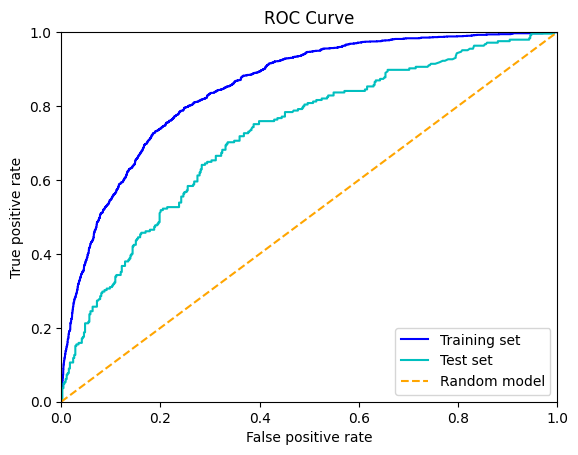



ROC-AUC Score - train set:  0.8502621183941557

ROC-AUC Score - test set:  0.7231959450446845



Accuracy - train set:  0.7777917505030181

Accuracy - test set:  0.6306818181818182



Cross validation score: 0.8438803152765525


In [75]:
#evaluar modelo
roc_auc_lr_train, roc_auc_lr_test, acc_lr_train, acc_lr_test = metrics_plot(features_ohe, target, features_train_ohe, features_test_ohe,
                                                                            target_train_ohe, target_test_ohe, model_lr)

Se observa una buena calidad del modelo y no hay sobreajuste.

**Datos del año 2019**

Se usan los datos del año 2019 con OHE.

In [76]:
#establecer modelo y entrenarlo
model_lr19 = LogisticRegression(solver='newton-cholesky')

model_lr19.fit(features_train_ohe19, target_train_ohe19)

LogisticRegression(solver='newton-cholesky')

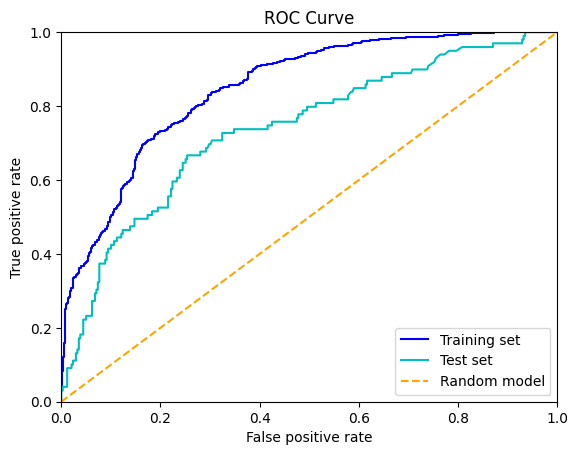



ROC-AUC Score - train set:  0.8489079156566841

ROC-AUC Score - test set:  0.7377908882333661



Accuracy - train set:  0.8022019741837509

Accuracy - test set:  0.3287671232876712



Cross validation score: 0.8438803152765525


In [77]:
#evaluar modelo
roc_auc_lr_train19, roc_auc_lr_test19, acc_lr_train19, acc_lr_test19 = metrics_plot(features_ohe, target, features_train_ohe19,
                                                                                    features_test_ohe19, target_train_ohe19, target_test_ohe19, model_lr19)


**Modelo de regresión logística con uso de descenso de gradiente estocástico - Datos históricos**

El modelo *`SGDClassifier`* no cuenta con el calculo de probabilidades, se usa junto con *`CalibratedClassifierCV`* para calcularlas y poder obtener la métrica *`AUC-ROC`*.

In [78]:
#establecer modelo y entrenarlo
model_sgd = SGDClassifier(loss='log_loss')
model_sgd_fitted =  model_sgd.fit(features_train_ohe, target_train_ohe)

model_sgd_cal = CalibratedClassifierCV(model_sgd_fitted)
model_sgd_cal.fit(features_train_ohe, target_train_ohe)

CalibratedClassifierCV(estimator=SGDClassifier(loss='log_loss'))

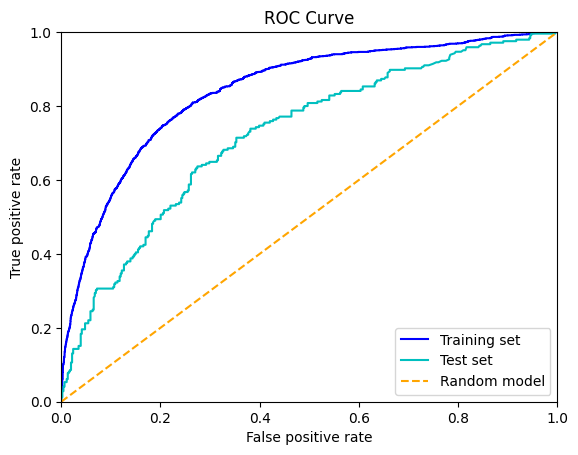



ROC-AUC Score - train set:  0.841369806851312

ROC-AUC Score - test set:  0.7221466364323508



Accuracy - train set:  0.7745221327967807

Accuracy - test set:  0.5880681818181818



Cross validation score: 0.842500961019209


In [79]:
#evaluar modelo
roc_auc_sgd_train, roc_auc_sgd_test, acc_sgd_train, acc_sgd_test = metrics_plot(features_ohe, target, features_train_ohe,
                                                                                features_test_ohe, target_train_ohe, target_test_ohe, model_sgd_cal)

**Modelo de regresión logística con uso de descenso de gradiente estocástico - Datos del año 2019**

In [80]:
#establecer modelo y entrenarlo
model_sgd19 = SGDClassifier()
model_sgd_fitted19 =  model_sgd19.fit(features_train_ohe19, target_train_ohe19)

model_sgd_cal19 = CalibratedClassifierCV(model_sgd_fitted19)
model_sgd_cal19.fit(features_train_ohe19, target_train_ohe19)

CalibratedClassifierCV(estimator=SGDClassifier())

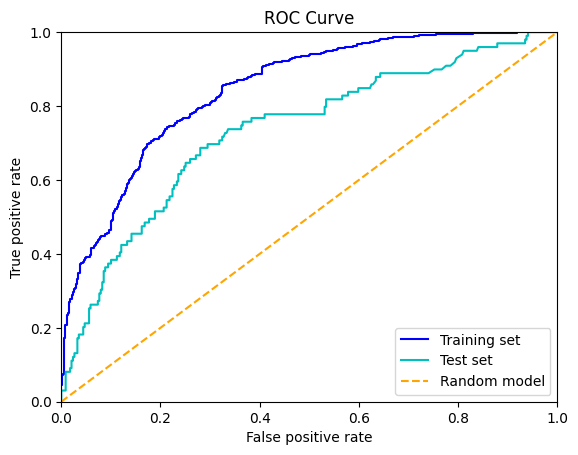



ROC-AUC Score - train set:  0.8445617327390726

ROC-AUC Score - test set:  0.7320997586484311



Accuracy - train set:  0.7930903568716781

Accuracy - test set:  0.4474885844748858



Cross validation score: 0.7857786112751196


In [81]:
#evaluar modelo
roc_auc_sgd_train19, roc_auc_sgd_test19, acc_sgd_train19, acc_sgd_test19 = metrics_plot(features_ohe19, target19, features_train_ohe19, features_test_ohe19,
                                                                                        target_train_ohe19, target_test_ohe19, model_sgd_cal19)

### Modelo árbol de clasificación

**Datos históricos**

Se usan los datos históricos con OHE.

In [82]:
#usar GridSearchCV para encontrar la mejor profundidad de árbol
param_grid = {'max_depth': [1,2,4,6,8,10,15,20]}

tree = DecisionTreeClassifier(random_state=12345)
grid_search_dt = GridSearchCV(estimator=tree, param_grid=param_grid, verbose=True, scoring='roc_auc')

grid_search_dt.fit(features_train_ohe, target_train_ohe)
grid_search_dt.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


DecisionTreeClassifier(max_depth=2, random_state=12345)

Las características anteriores se toman como referencia. Se modifica el modelo para evitar el sobreajuste.

In [83]:
#establecer modelo y entrenarlo
model_dt = DecisionTreeClassifier(max_depth=4, random_state=12345)
model_dt.fit(features_train_ohe, target_train_ohe)

DecisionTreeClassifier(max_depth=4, random_state=12345)

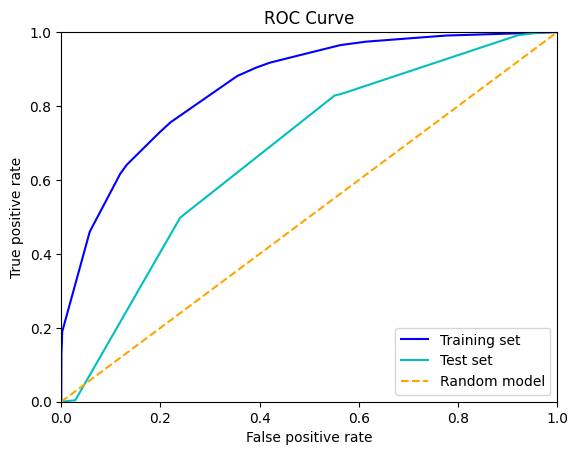



ROC-AUC Score - train set:  0.8563487394649978

ROC-AUC Score - test set:  0.6747632386287848



Accuracy - train set:  0.7752766599597586

Accuracy - test set:  0.3963068181818182



Cross validation score: 0.6445290985888786


In [84]:
#evaluar modelo
roc_auc_dt_train, roc_auc_dt_test, acc_dt_train, acc_dt_test = metrics_plot(features_ohe, target, features_train_ohe, features_test_ohe,
                                                                            target_train_ohe, target_test_ohe, model_dt)



**Datos del año 2019**

Se usan los datos del año 2019 con OHE.

In [85]:
#usar GridSearchCV para encontrar la mejor profundidad de árbol
param_grid = {'max_depth': [1,2,4,6,8,10,15,20]}

tree19 = DecisionTreeClassifier(random_state=12345)
grid_search_dt19 = GridSearchCV(estimator=tree19, param_grid=param_grid, verbose=True, scoring='roc_auc')

grid_search_dt19.fit(features_train_ohe19, target_train_ohe19)
grid_search_dt19.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


DecisionTreeClassifier(max_depth=4, random_state=12345)

Las características anteriores se toman como referencia. Se modifica el modelo para evitar el sobreajuste.

In [86]:
#establecer modelo y entrenarlo
model_dt19 = DecisionTreeClassifier(max_depth=3, random_state=12345)
model_dt19.fit(features_train_ohe19, target_train_ohe19)

DecisionTreeClassifier(max_depth=3, random_state=12345)

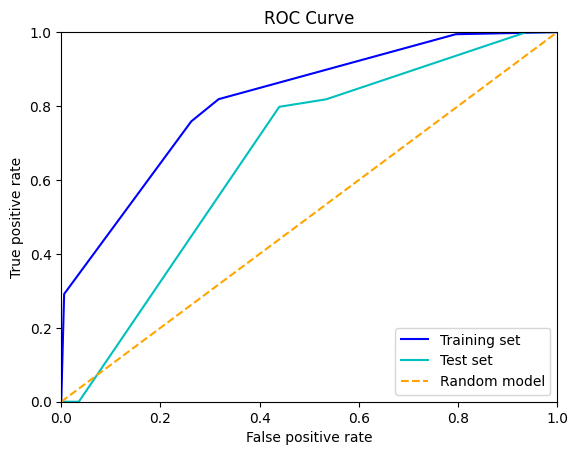



ROC-AUC Score - train set:  0.8163604138973596

ROC-AUC Score - test set:  0.6668603438514943



Accuracy - train set:  0.7737281700835231

Accuracy - test set:  0.273972602739726



Cross validation score: 0.6743863614879834


In [87]:
#evaluar modelo
roc_auc_dt_train19, roc_auc_dt_test19, acc_dt_train19, acc_dt_test19 = metrics_plot(features_ohe19, target19, features_train_ohe19,
                                                                                    features_test_ohe19, target_train_ohe19, target_test_ohe19, model_dt19)

### Modelo bosque aleatorio para clasificación

**Datos históricos**

Se usan los datos históricos con OHE.

In [88]:
#buscar las mejores características para los datos disponibles
param_grid = {'n_estimators': [1,2,3,4,6,8,10,20],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,8,10,20]}

model_rfc = RandomForestClassifier(random_state=12345)
grid_search_rfc = GridSearchCV(estimator=model_rfc, param_grid=param_grid, scoring='roc_auc')

grid_search_rfc.fit(features_train_ohe, target_train_ohe)
grid_search_rfc.best_params_

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 8}

Las características anteriores se toman como referencia. Se modifica el modelo para evitar el sobreajuste.

In [89]:
#establecer modelo y entrenarlo
model_rfc = RandomForestClassifier(max_depth=3, max_features='sqrt', n_estimators=6, random_state=12345)
model_rfc.fit(features_train_ohe, target_train_ohe)

RandomForestClassifier(max_depth=3, n_estimators=6, random_state=12345)

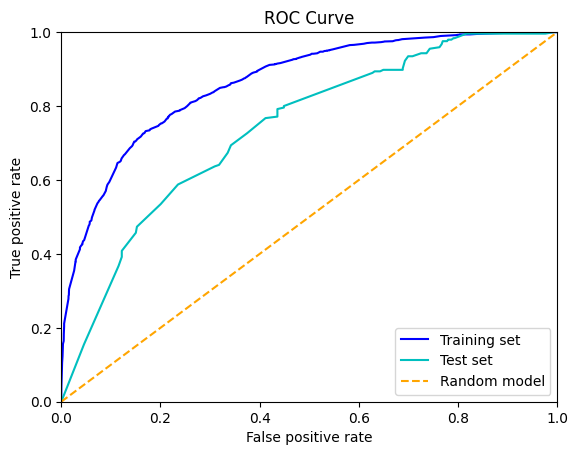



ROC-AUC Score - train set:  0.8621524810663181

ROC-AUC Score - test set:  0.7389933751278289



Accuracy - train set:  0.7857142857142857

Accuracy - test set:  0.38636363636363635



Cross validation score: 0.8410254318923146


In [90]:
#evaluar modelo
roc_auc_rcf_train, roc_auc_rcf_test, acc_rcf_train, acc_rcf_test = metrics_plot(features_ohe, target, features_train_ohe, features_test_ohe,
                                                                                target_train_ohe, target_test_ohe, model_rfc)

**Datos del año 2019**

Se usan los datos del año 2019 con OHE.

In [91]:
#buscar las mejores características para los datos disponibles
param_grid = {'n_estimators': [1,2,3,4,6,8,10,20],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,8,10,20]}

model_rfc19 = RandomForestClassifier(random_state=12345)
grid_search_rfc19 = GridSearchCV(estimator=model_rfc19, param_grid=param_grid, scoring='roc_auc')

grid_search_rfc19.fit(features_train_ohe19, target_train_ohe19)
grid_search_rfc19.best_params_

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 20}

Las características anteriores se toman como referencia. Se modifica el modelo para evitar el sobreajuste.

In [92]:
#establecer modelo y entrenarlo
model_rfc19 = RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=20, random_state=12345)
model_rfc19.fit(features_train_ohe19, target_train_ohe19)

RandomForestClassifier(max_depth=5, n_estimators=20, random_state=12345)

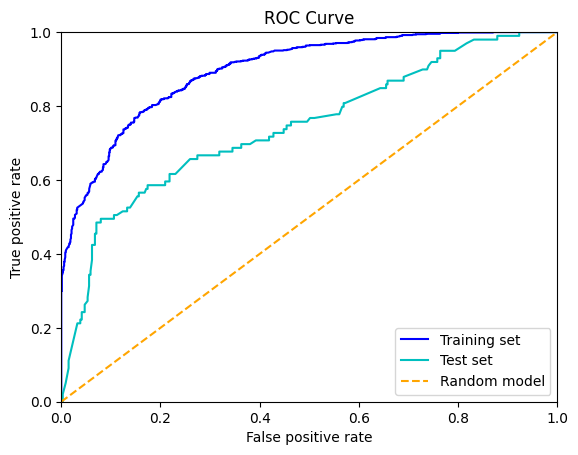



ROC-AUC Score - train set:  0.8971414236192561

ROC-AUC Score - test set:  0.7436756950031286



Accuracy - train set:  0.8223234624145785

Accuracy - test set:  0.23515981735159816



Cross validation score: 0.7426716930103088


In [93]:
#evaluar modelo
roc_auc_rcf_train19, roc_auc_rcf_test19, acc_rcf_train19, acc_rcf_test19 = metrics_plot(features_ohe19, target19, features_train_ohe19,
                                                                                        features_test_ohe19, target_train_ohe19, target_test_ohe19, model_rfc19)

### Modelo CatBoostClassifier

**Datos históricos**

Se usan los datos históricos sin OHE.

In [94]:
#explorar tipos de datos
features_train.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 7952 entries, 2013-10-01 to 2019-10-01

Data columns (total 16 columns):

 #   Column            Non-Null Count  Dtype  

---  ------            --------------  -----  

 0   Type              7952 non-null   object 

 1   PaperlessBilling  7952 non-null   int64  

 2   PaymentMethod     7952 non-null   object 

 3   MonthlyCharges    7952 non-null   float64

 4   TotalCharges      7952 non-null   float64

 5   InternetService   7952 non-null   object 

 6   OnlineSecurity    7952 non-null   int64  

 7   OnlineBackup      7952 non-null   int64  

 8   DeviceProtection  7952 non-null   int64  

 9   TechSupport       7952 non-null   int64  

 10  StreamingTV       7952 non-null   int64  

 11  StreamingMovies   7952 non-null   int64  

 12  SeniorCitizen     7952 non-null   int64  

 13  Partner           7952 non-null   int64  

 14  Dependents        7952 non-null   int64  

 15  MultipleLines     7952 non-null   int64  

dtypes: 

In [95]:
#identificar datos categoricos
train_data = Pool(data = features_train, label = target_train, cat_features = [0,2,5])
test_data =  Pool(data = features_test, label = target_test, cat_features = [0,2,5])

In [96]:
#transformar características categóricas de todo el conjunto de datos y del entrenamiento por separado
features_cb = features.apply(LabelEncoder().fit_transform)

features_train_cb = features_train.apply(LabelEncoder().fit_transform)

In [97]:
#buscar las mejores características
param_cb={'depth':[4, 6, 8, 10], 'learning_rate':[0.5, 0.1, 0.01], 'iterations':[10, 30, 50, 100]}

model_cb=CatBoostClassifier(random_seed=123456, verbose=False)
grid_cb=GridSearchCV(estimator=model_cb, param_grid=param_cb, n_jobs=-1, scoring='roc_auc')

grid_cb.fit(features_train_cb, target_train)
grid_cb.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.01}

Las características anteriores se toman como referencia. Se modifica el modelo para evitar el sobreajuste.

In [98]:
#establecer modelo y entrenarlo
model_cb = CatBoostClassifier(depth=3, iterations=70, learning_rate=0.05, random_seed=123456, verbose=False)
model_cb.fit(train_data)

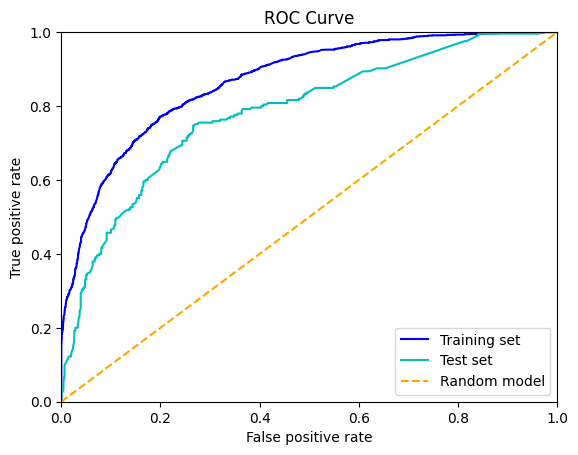



ROC-AUC Score - train set:  0.8675407393560872

ROC-AUC Score - test set:  0.7834244809034725



Accuracy - train set:  0.7876006036217303

Accuracy - test set:  0.3849431818181818



Cross validation score: 0.8160584849215397


In [99]:
#evaluar modelo
roc_auc_cb_train, roc_auc_cb_test, acc_cb_train, acc_cb_test = metrics_plot(features_cb, target, train_data, test_data, target_train, target_test, model_cb)

**Datos del año 2019**

Se usan los datos del año 2019 sin OHE.

In [100]:
#identificar datos categoricos
train_data19 = Pool(data = features_train19, label = target_train19, cat_features = [0,2,5])
test_data19 =  Pool(data = features_test19, label = target_test19, cat_features = [0,2,5])

In [101]:
#transformar características categóricas de todo el conjunto de datos y del entrenamiento por separado
features_cb19 = features19.apply(LabelEncoder().fit_transform)

features_train_cb19 = features_train19.apply(LabelEncoder().fit_transform)

In [102]:
#buscar las mejores características
param_cb={'depth':[4, 6, 8, 10], 'learning_rate':[0.5, 0.1, 0.01], 'iterations':[10, 30, 50, 100]}

model_cb19 = CatBoostClassifier(random_seed=123456, verbose=False)
grid_cb19 = GridSearchCV(estimator=model_cb19, param_grid=param_cb, n_jobs=-1, scoring='roc_auc')

grid_cb19.fit(features_train_cb19, target_train19)
grid_cb19.best_params_

{'depth': 6, 'iterations': 10, 'learning_rate': 0.5}

Las características anteriores se toman como referencia. Se modifica el modelo para evitar el sobreajuste.

In [103]:
#establecer modelo y entrenarlo
model_cb19 = CatBoostClassifier(depth=6, iterations=10, learning_rate=0.4, random_seed=123456, verbose=False)
model_cb19.fit(train_data19)

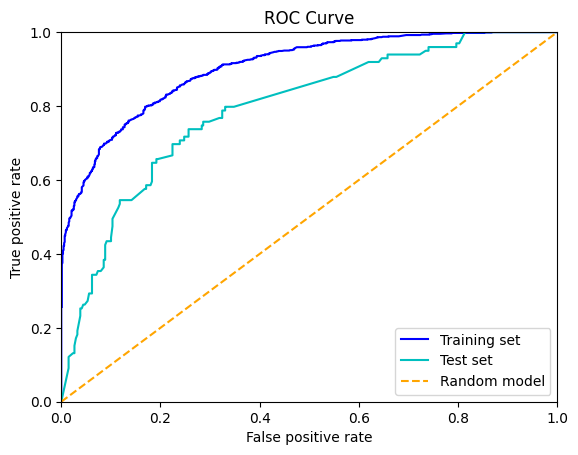



ROC-AUC Score - train set:  0.9032371569317382

ROC-AUC Score - test set:  0.7922737701498762



Accuracy - train set:  0.8318147304479878

Accuracy - test set:  0.2465753424657534



Cross validation score: 0.7397619593047715


In [104]:
#evaluar modelo
roc_auc_cb_train19, roc_auc_cb_test19, acc_cb_train19, acc_cb_test19 = metrics_plot(features_cb19, target19, train_data19, test_data19,
                                                                                    target_train19, target_test19, model_cb19)

## Conclusiones

**Comparación de modelos - datos históricos**

In [105]:
#Tabla con los valores AUC-ROC y exactitud de los modelos
table1 = pd.DataFrame({     'Model':['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier'],
       'ROC-AUC Score Training set':[roc_auc_lr_train, roc_auc_dt_train, roc_auc_rcf_train, roc_auc_cb_train],
       'ROC-AUC Score Test set'    :[roc_auc_lr_test,  roc_auc_dt_test,  roc_auc_rcf_test,  roc_auc_cb_test],
       'Accuracy Training set'     :[acc_lr_train,     acc_dt_train,     acc_rcf_train,     acc_cb_train],
       'Accuracy Test set'         :[acc_lr_test,      acc_dt_test,      acc_rcf_test,      acc_cb_test]})

table1.sort_values('ROC-AUC Score Test set', ascending=False)

,Model,ROC-AUC Score Training set,ROC-AUC Score Test set,Accuracy Training set,Accuracy Test set
3,CatBoostClassifier,0.867541,0.783424,0.787601,0.384943
2,RandomForestClassifier,0.862152,0.738993,0.785714,0.386364
0,LogisticRegression,0.850262,0.723196,0.777792,0.630682
1,DecisionTreeClassifier,0.856349,0.674763,0.775277,0.396307


**Comparación de modelos - datos del año 2019**

In [107]:
#Tabla con los valores AUC-ROC y exactitud de los modelos
table1 = pd.DataFrame({     'Model':['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier'],
       'ROC-AUC Score Training set':[roc_auc_lr_train19, roc_auc_dt_train19, roc_auc_rcf_train19, roc_auc_cb_train19],
       'ROC-AUC Score Test set'    :[roc_auc_lr_test19,  roc_auc_dt_test19,  roc_auc_rcf_test19,  roc_auc_cb_test19],
       'Accuracy Training set'     :[acc_lr_train19,     acc_dt_train19,     acc_rcf_train19,     acc_cb_train19],
       'Accuracy Test set'         :[acc_lr_test19,      acc_dt_test19,      acc_rcf_test19,      acc_cb_test19]})

table1.sort_values('ROC-AUC Score Test set', ascending=False)

,Model,ROC-AUC Score Training set,ROC-AUC Score Test set,Accuracy Training set,Accuracy Test set
3,CatBoostClassifier,0.903237,0.792274,0.831815,0.246575
2,RandomForestClassifier,0.897141,0.743676,0.822323,0.235160
0,LogisticRegression,0.848908,0.737791,0.802202,0.328767
1,DecisionTreeClassifier,0.816360,0.666860,0.773728,0.273973


Al comparar los modelos, en ambas tablas tienen el mismo orden de exito y el modelo **CatBoostClassifier** tiene el `ROC-AUC Score` más alto en el conjunto de prueba.

Tomando como métrica el valor `ROC-AUC Score`, comparando el modelo que toma los datos históricos contra los datos del año 2019, este último conjunto da un `ROC-AUC Score` ligeramente mayor al de los datos históricos. Sin embargo, al tomar los datos históricos se obtiene un valor de `exactitud` (`Accuracy`) significativamente mayor en el conjunto de datos de prueba. Por ello, se recomienda usar el modelo **CatBoostClassifier** con los datos históricos.

En general, los resultados `ROC-AUC Score` de los modelos que solo tomaron los datos del 2019 fueron mejores que los que usaron datos históricos cosa que podría significar que falta información y es recomendable recabar más datos.

